<a href="https://colab.research.google.com/drive/1Pbia_nScgqyGFPUTxqLDQA5k81pAGNrl?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


# **RecyCam**: Ask this model if the trash is recyclables

By Claire, Isha, Sebin, Ziyu

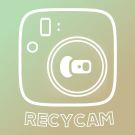

Ever paused before two trash bins, unsure where to toss your waste?

We're tackling this with Tag2Text model. Give it a whirl!



# Part 1: Import necessary libraries and define functions

## 1.1 Import dependencies

In [1]:

import ipywidgets as widgets
from IPython.display import clear_output, display, Image
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1.2 Clone the repository

In [2]:
!git clone https://github.com/xinyu1205/recognize-anything.git

%cd recognize-anything
!git checkout ec6b4241c5036e337a4543838deb9bff4990de97

clear_output()

## 1.3 Install dependencies

In [3]:
!pip install timm transformers fairscale pycocoevalcap

clear_output()

## 1.4 Image recognition model setup

In [4]:
# define which model to use and how many images at a time
model = "Tag2Text"# model_widget.value
task = "one image"

In [5]:
def download_checkpoints(model):
    # print('You selected', model)
    if not os.path.exists('pretrained'):
        os.makedirs('pretrained')

    if model == "RAM":
        ram_weights_path = 'pretrained/ram_swin_large_14m.pth'
        if not os.path.exists(ram_weights_path):
            !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth -O pretrained/ram_swin_large_14m.pth
        # else:
            # print("RAM weights already downloaded!")
    else:
        tag2text_weights_path = 'pretrained/tag2text_swin_14m.pth'
        if not os.path.exists(tag2text_weights_path):
            !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/tag2text_swin_14m.pth -O pretrained/tag2text_swin_14m.pth
        # else:
            # print("Tag2Text weights already downloaded!")

download_checkpoints(model)
# print(model, 'weights are downloaded!')
clear_output()

In [6]:
image_path = '/content/uploaded_image.jpg'

def run_inference(model, task):
    if model == "Tag2Text" and task == "one image":
        !python inference_tag2text.py  --image {image_path} \
        --pretrained pretrained/tag2text_swin_14m.pth
    elif model == "Tag2Text" and task == "multiple images":
        !python batch_inference.py --image-dir {images_dir} \
        --pretrained pretrained/tag2text_swin_14m.pth --model-type tag2text
    elif model == "RAM" and task == "one image":
        !python inference_ram.py  --image {image_path} \
        --pretrained pretrained/ram_swin_large_14m.pth
    elif model == "RAM" and task == "multiple images":
        !python batch_inference.py --image-dir {images_dir} \
        --pretrained pretrained/ram_swin_large_14m.pth --model-type ram
    else:
        print('Invalid model or task')


## 1.5 Web scraping and google search setup

In [7]:
!pip install selenium

import requests
from bs4 import BeautifulSoup

from selenium import webdriver #webdriver is like a function called from the file
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
# from universities import school_list
#without 'from', we are importing the file itself
#import selenium vs from ... import...
import time

def basicCanRecycle():
    url="https://www.phila.gov/programs/recycling-program/what-to-recycle/"
    headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
    req=requests.get(url, headers=headers)
    soup=BeautifulSoup(req.content,"html5lib")
    #print(soup)
    data=soup.findAll("h4")
    totalList=[]
    for i in range(0,len(data)-1):
        totalList.append(data[i].get_text())
    #print(totalList)
    canRecycle=[]
    for i in range(0,6):
        canRecycle.append(totalList[i])

    return canRecycle

def basicCannotRecycle():
    url="https://www.phila.gov/programs/recycling-program/what-to-recycle/"
    headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
    req=requests.get(url, headers=headers)
    soup=BeautifulSoup(req.content,"html5lib")
    data=soup.findAll("h4")
    totalList=[]
    for i in range(0,len(data)):
        totalList.append(data[i].get_text())
    #print(totalList)
    cannotRecycle=[]
    for i in range(6,len(totalList)-1):
        cannotRecycle.append(totalList[i])

    return cannotRecycle

def cannotRecycleExamples():
    url="https://www.phila.gov/programs/recycling-program/what-to-recycle/"
    headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}
    req=requests.get(url, headers=headers)
    soup=BeautifulSoup(req.content,"html5lib")
    data=soup.findAll("li")
    examples=[]
    for i in range(66,78):
        examples.append(data[i].get_text())

    return examples

clear_output()

In [8]:
from selenium import webdriver #webdriver is like a function called from the file
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import webdriver_manager.chrome
import time
chrome_options = Options()

# driver = webdriver.Chrome(ChromeDriverManager().install())

## 1.6 Category match setup

In [9]:
!pip install fuzzywuzzy
clear_output()

In [10]:
trash = cannotRecycleExamples()

def listToString(s):
    # initialize an empty string
    str1 = " "
    # return string
    return (str1.join(s))

sepe = []
for item in trash:
  item = item.replace('and',',').replace('or',',').split(', ')
  # item = str(item)
  for i in item:
    i = i.split()
    string = listToString(i).lower()
    if string != '':
      sepe.append(string)

# Function to classify tags with fuzzy matching
def classify_tags_fuzzy(tags):
    categories = []
    for tag in tags:
        # Initialize variables to track the best match
        best_match = None
        best_score = 0
        best_category = "Unknown"

        # Iterate over each category and its items
        for category, items in waste_mapping.items():
            # Find the closest match within this category's items
            result = process.extractOne(tag.lower(), items, score_cutoff=80)
            if result:
                match, score = result
                # Update the best match if this score is higher
                if score > best_score:
                    best_match = match
                    best_score = score
                    best_category = category

        categories.append((tag, best_category))
    return categories


In [11]:
basicrecy = [i.lower() for i in basicCanRecycle()]
basicrecy.remove("plastics (labeled #1, #2, #5)")
# basicrecy

In [12]:
from fuzzywuzzy import process
recy = basicrecy + ["paper", "cardboard", "bottles", "containers", "glass", "steel", "cans", "recyclables"]
nonrecy = sepe + ["bags", "wrap", "waxy cups", "foam", "polystyrene", "wires", "medical waste", "syringes","trash"]

# Expanded mapping with more variations
waste_mapping = {
    "recyclables": recy,
    "non-recyclables": nonrecy
}

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Part 2: Upload an image

Saving cans.jpeg to cans (4).jpeg
File saved to /content/uploaded_image.jpg


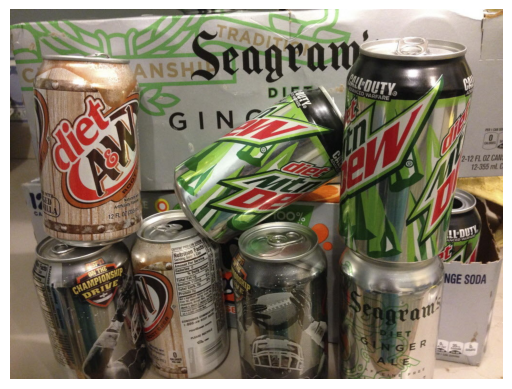

In [13]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Specify the target filepath
target_filepath = '/content/uploaded_image.jpg'

# Save the uploaded file to the specific filepath
file_name = next(iter(uploaded))
with open(target_filepath, 'wb') as f:
    f.write(uploaded[file_name])
print(f'File saved to {target_filepath}')

# show the image uploaded
img = mpimg.imread(target_filepath)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# Part 3: Run the model

It might take about some time for the model to give a result:)

In [14]:
#@title Run and save outputs
import io
import sys

# Redirect the standard output to a string buffer
old_stdout = sys.stdout
sys.stdout = io.StringIO()

# Run the model that prints the tags
run_inference(model, task)

# Get the output from the string buffer
output = sys.stdout.getvalue()

# Restore the original standard output
sys.stdout = old_stdout

# Process the output to extract tags
tags = output.strip().split('\n')  # Assuming each tag is printed on a new line

# only look at model identified tags
model_rec_tag = tags[-3]
caption = tags[-1]

# only pick the parts after ":"
parts = model_rec_tag.split(':  ')
object_tag = parts[1]

# seperate multiple tags into a list of strings
seperate_tag = object_tag.split(' | ')
seperate_tag

['drink', 'can']

# Part 4: Classify the tags into recylables or not

## Fuzzy match tags with dictionary

In [15]:
# 4.2 Fuzzy match tags with dictionary
classified_tags = classify_tags_fuzzy(seperate_tag)

# print out the result
counter = 0
for tag, category in classified_tags:
    # print(f"Tag: {tag}, Category: {category}")
    if category == 'recyclables':
        counter += 1
    elif category == 'non-recyclables':
        counter -= 1
    else: counter += 0

# decide which category it belongs to
print(f"Image tag: {object_tag}")

if counter>0:
  print("This is recyclables.")
elif counter<0:
  print("This is non-recyclables.")
else:  print("Unknown")

Image tag: drink | can
This is recyclables.


# Part 5: Only detect words

In [16]:
# Prompt the user to enter some words
user_input = input("Please enter some words: ")

# Initialize variables to track the best match
best_match = None
best_score = 0
best_category = "Unknown"

# Iterate over each category and its items
for category, items in waste_mapping.items():
    # Find the closest match within this category's items
    result = process.extractOne(user_input.lower(), items, score_cutoff=80)
    if result:
        match, score = result
        # Update the best match if this score is higher
        if score > best_score:
            best_match = match
            best_score = score
            best_category = category

print(f"{user_input}: {best_category}.")

Please enter some words: plastic bag
plastic bag: non-recyclables.


# Part 6: Search more info on google automatically

In [17]:
def googleSearch(item):


    chrome_options = Options()
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--headless")

    driver = webdriver.Chrome(options=chrome_options)

    url=f"https://www.google.com/search?q=is {item} recyclable"
    driver.get(url) #"runs" the url
    time.sleep(2) #if the page takes too long to load, time.sleep gives it more time and then searches

    #info=driver.find_element(By.XPATH,"//span[@class=\"hgKElc\"]")
    info=driver.find_element(By.CLASS_NAME, "hgKElc")

    #website=driver.find_element(By.CLASS_NAME, "qLRx3b tjvcx GvPZzd cHaqb")
    website=driver.find_element(By.XPATH,"//cite[@class=\"qLRx3b tjvcx GvPZzd cHaqb\"]")


    if info.text=="":
        print("Error. Recyclability is unknown.")
    else:
        print(info.text)
        print(f"From {website.text}")

In [18]:
# only pick the parts after ":"
# cap_parts = caption.split(':  ')
# object_caption = cap_parts[1]
# object_caption = "plastic bottle"

# item = input("What object would you like to know if it's recycable?")
item = seperate_tag
for i in item:
  print(i)
  googleSearch(i)
  print('------------')

drink
Error. Recyclability is unknown.
------------
can
All metal cans are infinitely recyclable. It doesn't matter if they are aluminum drink cans or tin, steel, or bi-metal food cans.
From https://lessismore.org › Materials
------------
